In [1]:
from pycalphad.core.solver import SolverBase, SolverResult, InteriorPointSolver

class NoOpSolver(SolverBase):
    ignore_convergence = True
    @staticmethod
    def solve(prob):
        return SolverResult(converged=False, x=prob.x0, chemical_potentials=None)
fastsolver = NoOpSolver()
ipsolver = InteriorPointSolver(verbose=False)

In [2]:
from pycalphad import Database, equilibrium, variables as v

dbf = Database('alzn_mey.tdb')

num_runs = 10
comps = ['AL', 'ZN', 'VA']
conds = {v.T: (300, 2000, 50), v.X('AL'): (0,1,0.02), v.P: 101325}
phases = sorted(dbf.phases.keys())

# Prime the cache
eq = equilibrium(dbf, comps, phases, conds, solver=fastsolver)

In [3]:
import time


start = time.perf_counter()

for _ in range(num_runs):
    eq_exact = equilibrium(dbf, comps, phases, conds, solver=ipsolver)
exact_tx = (time.perf_counter() - start) / num_runs

In [4]:
import numpy as np
results = []
for pdens in [10, 50, 100, 200, 300, 400, 500]:
    start = time.perf_counter()
    for _ in range(num_runs):
        eq = equilibrium(dbf, comps, phases, conds, solver=fastsolver, calc_opts={'pdens': pdens})
    tx = (time.perf_counter() - start) / num_runs
    results.append((pdens, exact_tx / tx, np.max(np.abs(eq.MU.values - eq_exact.MU.values))))

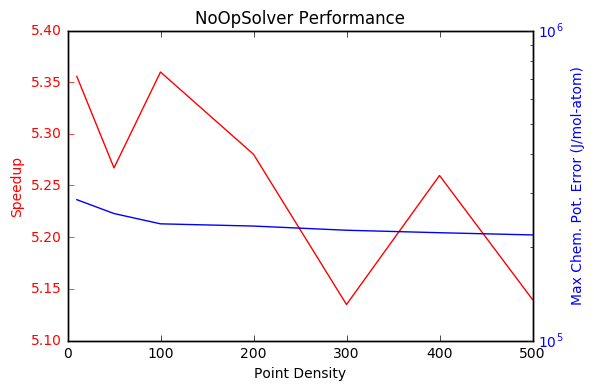

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
pdens, tx, err = zip(*results)

fig = plt.figure()
ax1 = fig.gca()
ax1.set_title('NoOpSolver Performance')
ax1.set_ylabel('Speedup', color='r')
ax1.plot(pdens, tx, color='r')
ax1.tick_params('y', colors='r')
ax1.set_xlabel('Point Density')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Max Chem. Pot. Error (J/mol-atom)', color='b')
ax2.plot(pdens, err, color='b')
ax2.tick_params('y', colors='b')